## Basic Operations<br>
#### Import Libraries

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

#### Reading datasets

In [2]:
train_df=pd.read_csv("Boston_Train.csv")
test_df=pd.read_csv("Boston_Test.csv")

#### Concating train and test datasets

In [3]:
data=pd.concat([train_df, test_df], axis=0)
data.head()

,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


#### Dataset details<br>


The Boston Housing Dataset is a derived from information collected by the U.S. 
Census Service concerning housing in the area of Boston MA. The following 
describes the dataset columns:<br><br>
* CRIM - per capita crime rate by town<br>
* ZN - proportion of residential land zoned for lots over 25,000 sq. ft.  INDUS - proportion of non-retail business acres per town. <br>
* CHAS - Charles River dummy variable (1 if tract bounds river; 0 
otherwise)<br>
* NOX - nitric oxides concentration (parts per 10 million)<br>
* RM - average number of rooms per dwelling<br>
* AGE - proportion of owner-occupied units built prior to 1940<br>
* DIS - weighted distances to five Boston employment centers<br>
* RAD - index of accessibility to radial highways<br>
* TAX - full-value property-tax rate per $10,000<br>

* PTRATIO - pupil-teacher ratio by town<br>
* B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town<br>
* LSTAT - % lower status of the population<br>
* MEDV - Median value of owner-occupied homes in $1000'<br>

<br>
<br><br>
<br><br>
<br><br>
<br>
<br>We don't need 1st column (Unnamed:0) since it's a index column that we have already by default. So we should drop it from training and testing data set in order to prevent errors in ML model performance.

In [4]:
data=data.drop(['Unnamed: 0'], axis=1)
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


#### Finding null values and treating them<br>
Replacing all 0 values by NaN

In [5]:
data.replace(0,np.nan,inplace = True)
data.isnull().sum()

crim         0
zn         372
indus        0
chas       471
nox          0
rm           0
age          0
dis          0
rad          0
tax          0
ptratio      0
black        0
lstat        0
medv         0
dtype: int64

Finding missing value percentage

In [6]:
print("Percentage of missing values:")
display(data.isnull().sum()/len(data) * 100)

Percentage of missing values:


crim        0.000000
zn         73.517787
indus       0.000000
chas       93.083004
nox         0.000000
rm          0.000000
age         0.000000
dis         0.000000
rad         0.000000
tax         0.000000
ptratio     0.000000
black       0.000000
lstat       0.000000
medv        0.000000
dtype: float64

From above reuslts we can conclude that we have approxiately 63% missing values in zn feature and 92% in chas feature in train data set. As well as we have approxiately 96% missing values in zn feature and 94% in chas feature in train data set.<br>
So we have to remove those two features since we can not fill this amount of missing values which may increase the error in regresison models.

Dropping two features

In [7]:
data.drop(["zn", "chas"], axis=1, inplace=True)
data.isnull().sum()

crim       0
indus      0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64

#### Finding Outliers

In [8]:
def outlier_detect(DF):
    DF.plot(kind="box", subplots=True, layout=(4,4), figsize=(15,15));

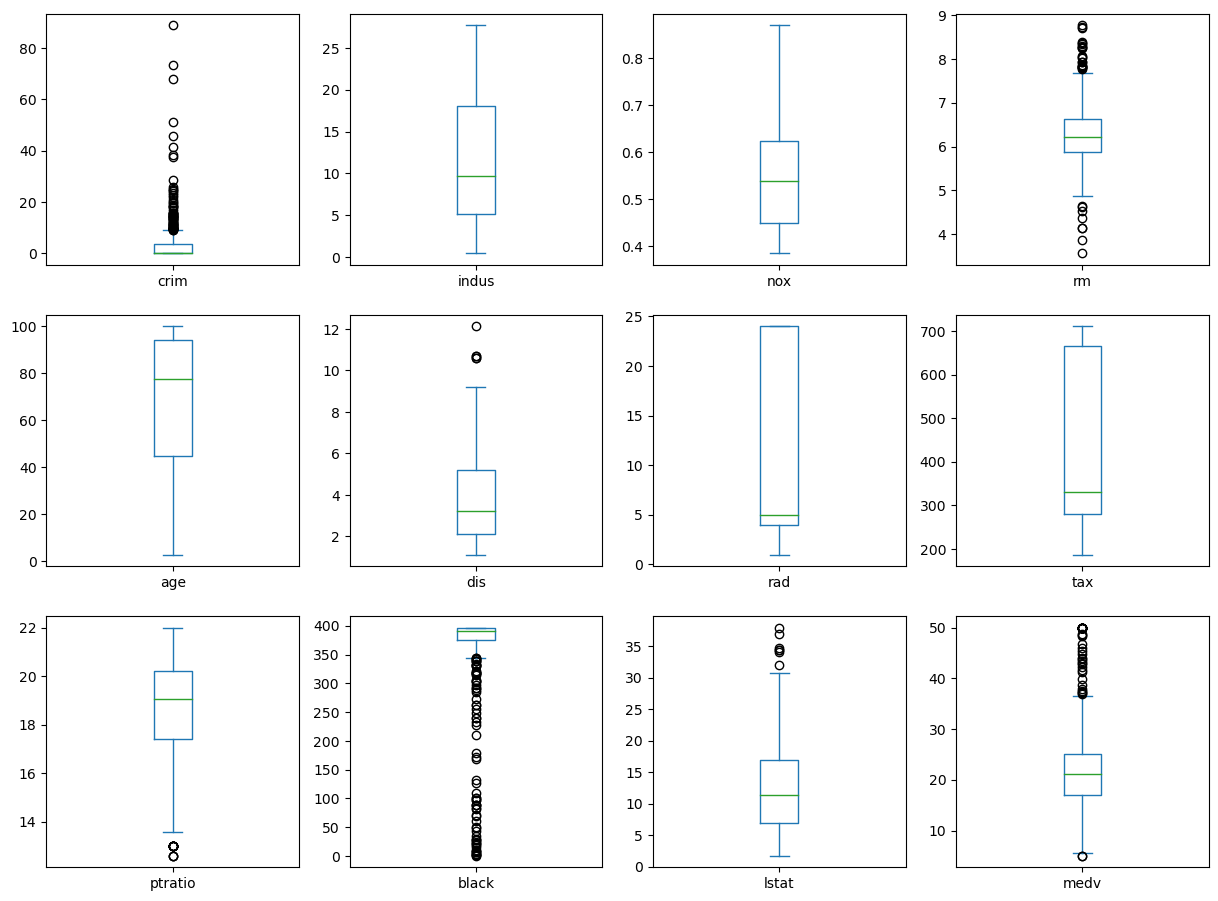

In [9]:
outlier_detect(data)

In [10]:
column_int=[]
column_obj=[]
for col in data:
    dataTypeObj = data.dtypes[col]
    if dataTypeObj == np.int64 or dataTypeObj == np.float64 :
        column_int.append(col)
    if dataTypeObj== np.object:
        column_obj.append(col)

In [11]:
#we removed output feature name from the list, beacuse in x, the output column name dows not exist
column_int.remove("medv")

In [12]:
for i in column_int:
    Q3=np.percentile(data[i], 75)
    Q1=np.percentile(data[i], 25)
    IQR=Q3-Q1
    UB=Q3+(1.5*IQR)
    LB=Q1-(1.5*IQR)

    data[i]=data[i].apply(lambda x:UB if x>UB else x)
    data[i]=data[i].apply(lambda y:LB if y<LB else y)

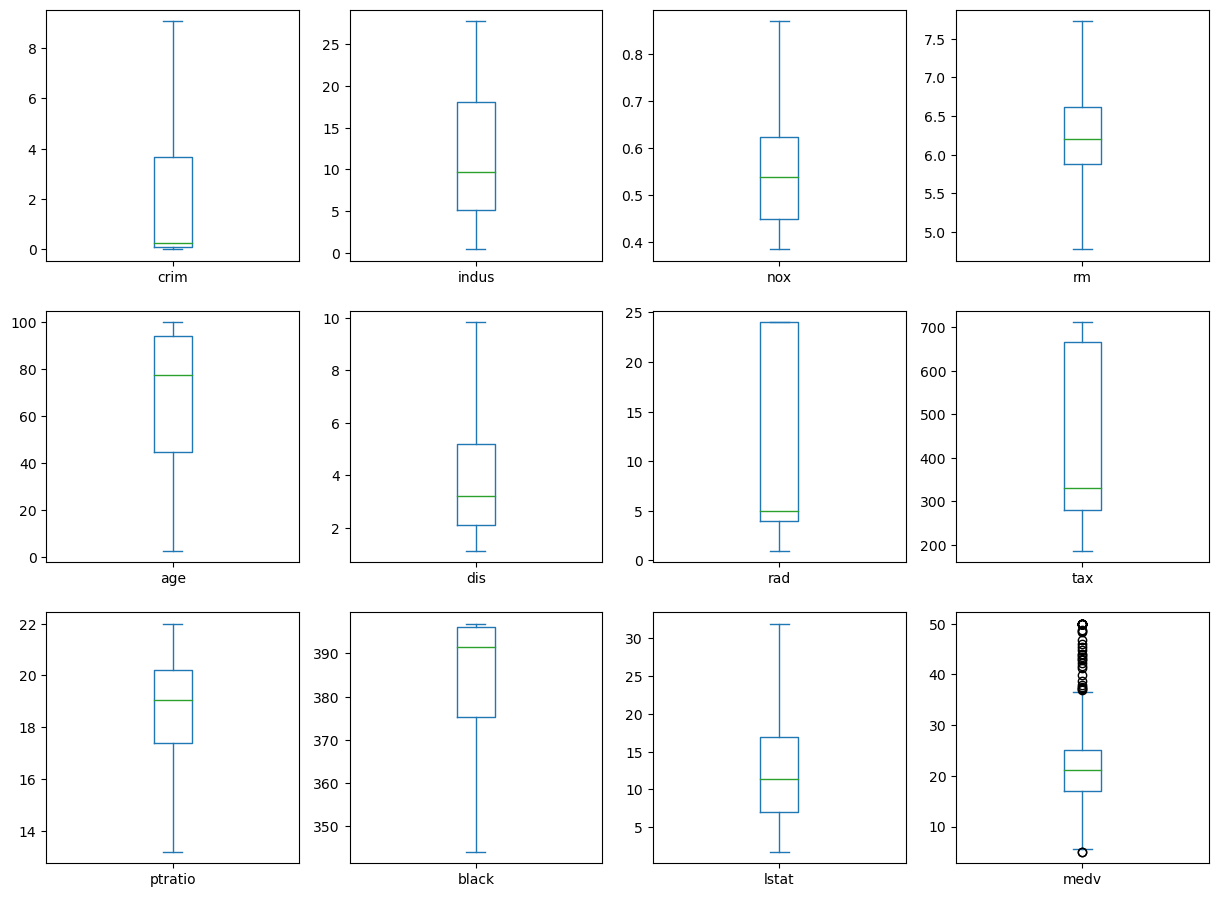

In [13]:
outlier_detect(data)

From the above box plot we can see the we removed all outliers from the input features.

Checking data shape and statistical details

In [14]:
data.shape

(506, 12)

In [15]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
crim,506.0,2.225032,3.313353,0.00632,0.082045,0.25651,3.677083,9.069639
indus,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.740000
nox,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.871000
rm,506.0,6.275312,0.630242,4.77850,5.885500,6.20850,6.623500,7.730500
age,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.000000
dis,506.0,3.783947,2.069765,1.12960,2.100175,3.20745,5.188425,9.820800
rad,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.000000
tax,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.000000
ptratio,506.0,18.463834,2.143924,13.20000,17.400000,19.05000,20.200000,22.000000
black,506.0,381.918836,19.054913,344.10625,375.377500,391.44000,396.225000,396.900000


Checking distribution pattern of target variable

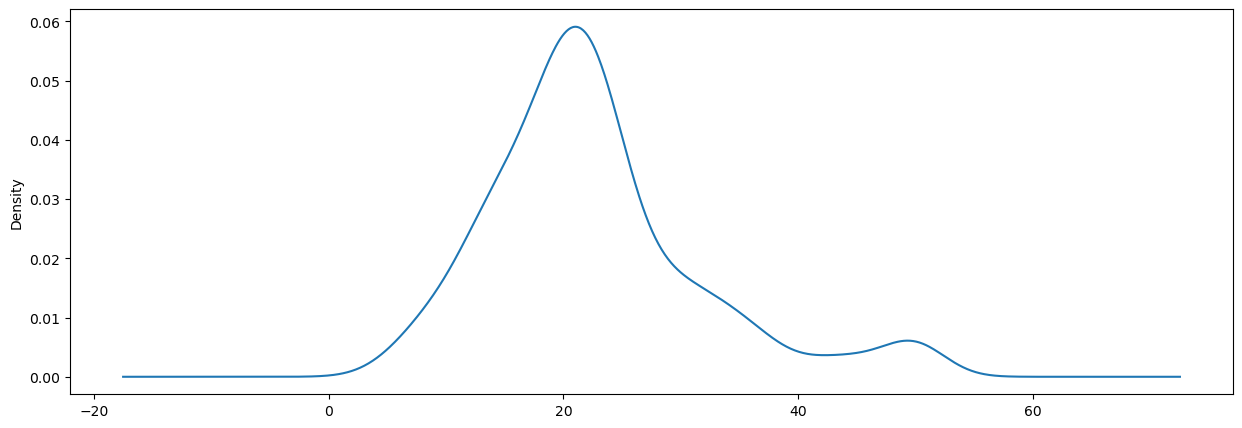

In [16]:
data['medv'].plot(kind='kde', figsize=(15,5));

We have slight right skewed distributed outcome with some outliers which may not affect the performance of the model.

#### Checking the correlation of each independent variable with out target variable

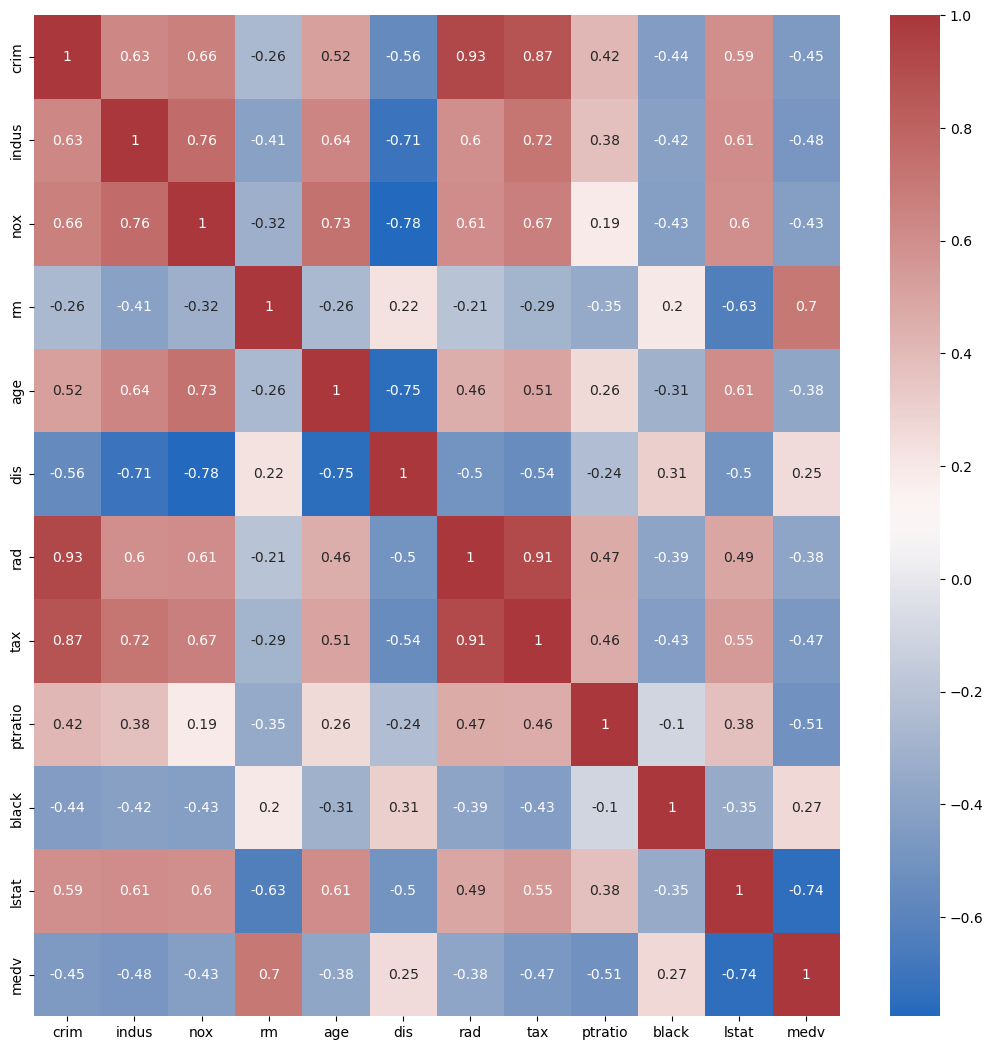

In [17]:
plt.figure(figsize=(13,13))
sns.heatmap(data.corr(), cbar=True, annot=True, cmap='vlag');

From the correlation heatmap, we can say that, the output feature i.e. medv has strong correlation with "lstat","ptratio","rm","nox","indus","crim","tax".
So we have to consider histogram for all those correlated columns individually.

Text(0, 0.5, 'medv')

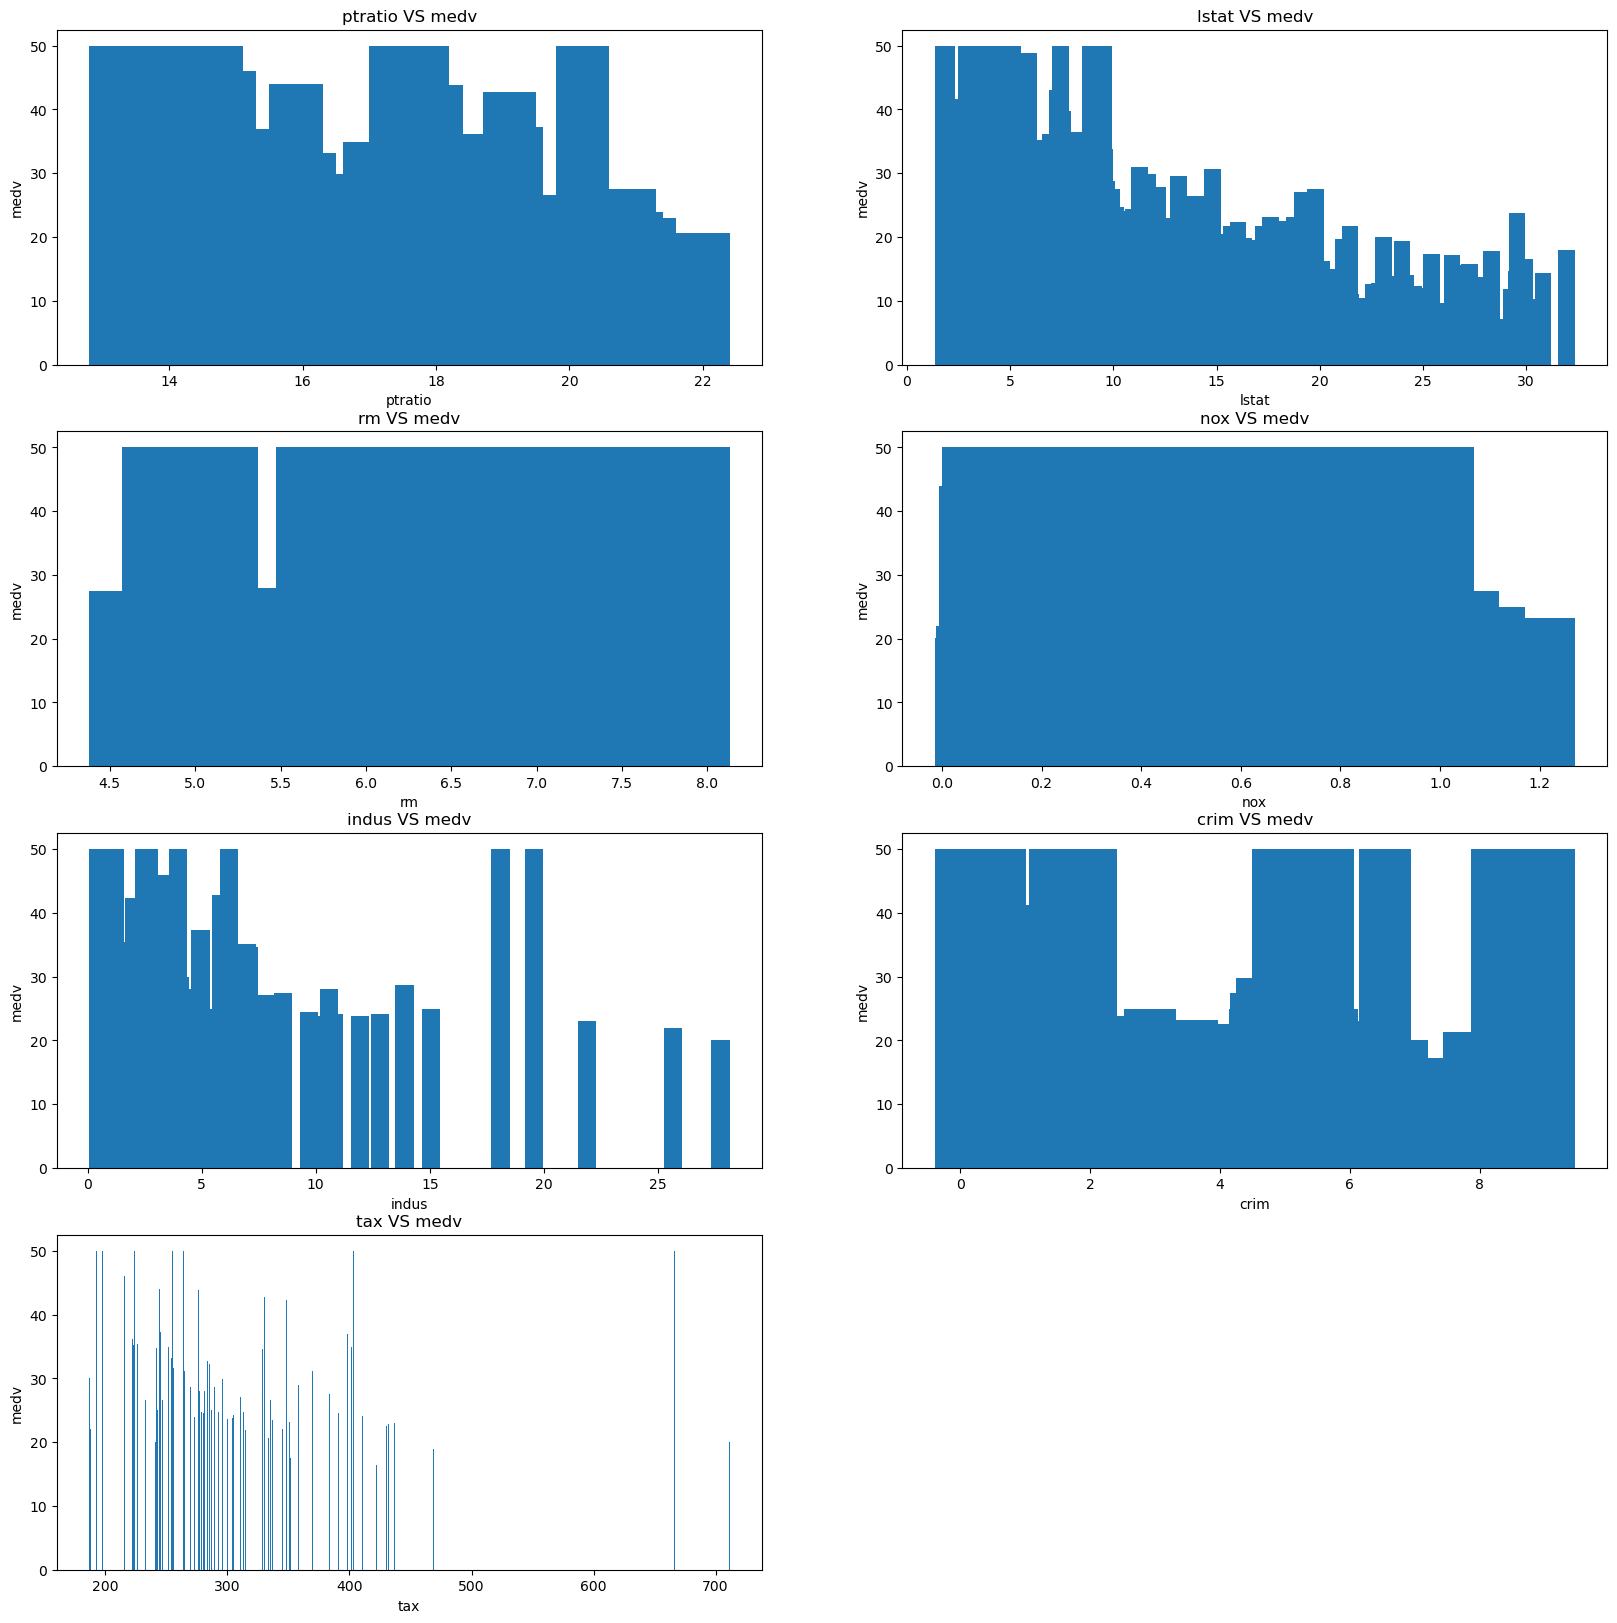

In [18]:
fig=plt.figure(figsize=(20,20))  

ax1=fig.add_subplot(4,2,1)   
ax2=fig.add_subplot(4,2,2)
ax3=fig.add_subplot(4,2,3)
ax4=fig.add_subplot(4,2,4)
ax5=fig.add_subplot(4,2,5)
ax6=fig.add_subplot(4,2,6)
ax7=fig.add_subplot(4,2,7)





ax1.bar(data.ptratio, data.medv)
ax1.set_title("ptratio VS medv")
ax1.set_xlabel("ptratio")
ax1.set_ylabel("medv")

ax2.bar(data.lstat, data.medv)
ax2.set_title("lstat VS medv")
ax2.set_xlabel("lstat")
ax2.set_ylabel("medv")

ax3.bar(data.rm, data.medv)
ax3.set_title("rm VS medv")
ax3.set_xlabel("rm")
ax3.set_ylabel("medv")

ax4.bar(data.nox, data.medv)
ax4.set_title("nox VS medv")
ax4.set_xlabel("nox")
ax4.set_ylabel("medv")

ax5.bar(data.indus, data.medv)
ax5.set_title("indus VS medv")
ax5.set_xlabel("indus")
ax5.set_ylabel("medv")

ax6.bar(data.crim, data.medv)
ax6.set_title("crim VS medv")
ax6.set_xlabel("crim")
ax6.set_ylabel("medv")

ax7.bar(data.tax, data.medv)
ax7.set_title("tax VS medv")
ax7.set_xlabel("tax")
ax7.set_ylabel("medv")



#### From above subplots, we can say,<br>
* ptratio is inversly proportional with medv<br>
* lstat is inversly proportional with medv<br>
* rm is directly proportional with medv<br>
* nox is inversly proportional with medv<br>
* indus is inversly proportional with medv<br>
* crim is inversly proportional with medv<br>
* tax is inversly proportional with medv<br>

In this stage we have cleaned almost the entire data set now we can proceed to fit into multiple regression models.

#### Splitting into dependent and independent features

In [19]:
X=data.drop(["medv"], axis=1)
Y=data["medv"]

In [20]:
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (506, 11)
Shape of Y: (506,)


#### Train Test Spliting

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
x_train, x_test, y_train, y_test=train_test_split(X, Y, train_size=0.70)

In [23]:
print("Shape of X train:",x_train.shape)
print("Shape of Y train:",y_train.shape)
print("Shape of X test:",x_test.shape)
print("Shape of Y test:",y_test.shape)

Shape of X train: (354, 11)
Shape of Y train: (354,)
Shape of X test: (152, 11)
Shape of Y test: (152,)


#### Normalizing the data

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train_scaled=scaler.transform(x_train)
x_test_scaled=scaler.transform(x_test)

## Regression model

Evaluate metrics

In [25]:
def model_evaluate(y_test,y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print('MAE is {}'.format(round(mae, 3)))
    print('MSE is {}'.format(round(mse, 3)))
    print('R2 score is {}'.format(round(r2, 3)))
    

#### Linear Regression

Scores of Linear Regression:
MAE is 3.575
MSE is 25.836
R2 score is 0.719


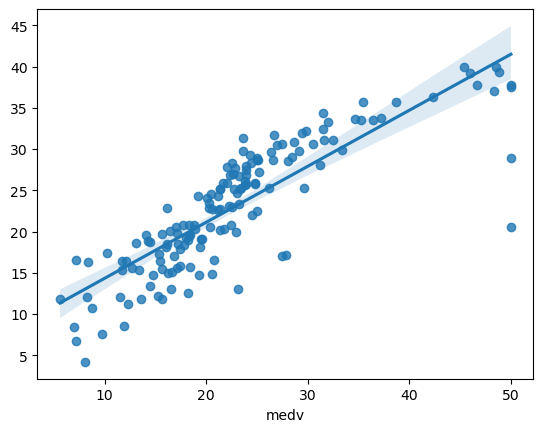

In [26]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(x_train_scaled, y_train)
y_pred_lr=lr.predict(x_test_scaled)
print("Scores of Linear Regression:")
model_evaluate(y_test,y_pred_lr)
sns.regplot(x=y_test,y=y_pred_lr)
plt.show()

#### Decision Tree

In [27]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()
dt.fit(x_train_scaled, y_train)
y_pred=dt.predict(x_test_scaled)
print("Scores of DT Regression:")
model_evaluate(y_test,y_pred)

Scores of DT Regression:
MAE is 3.149
MSE is 20.351
R2 score is 0.779


In [28]:
parameter={"max_depth" : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
kf=KFold(n_splits=10)
grid_sv = GridSearchCV(dt, cv=kf, param_grid=parameter, scoring='neg_mean_absolute_error')
grid_sv.fit(x_train_scaled, y_train)
print("Best classifier :", grid_sv.best_estimator_)

Best classifier : DecisionTreeRegressor(max_depth=5)


Scores of DT Regression:
MAE is 3.062
MSE is 18.564
R2 score is 0.798


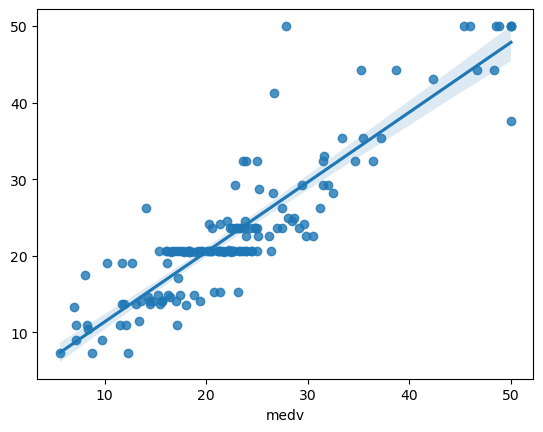

In [29]:
DT = DecisionTreeRegressor(max_depth=7)
DT.fit(x_train_scaled, y_train)
y_pred_DT=DT.predict(x_test_scaled)
print("Scores of DT Regression:")
model_evaluate(y_test,y_pred_DT)
sns.regplot(x=y_test,y=y_pred_DT)
plt.show()

#### KNN 

Scores of KNN Regression:
MAE is 3.149
MSE is 20.351
R2 score is 0.779


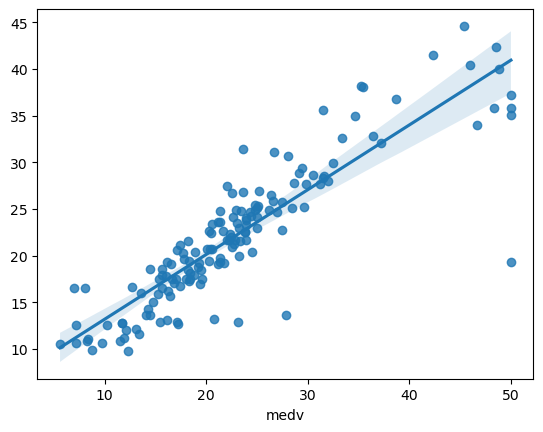

In [30]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(x_train_scaled, y_train)
y_pred_knn=knn.predict(x_test_scaled)
print("Scores of KNN Regression:")
model_evaluate(y_test,y_pred)
sns.regplot(x=y_test,y=y_pred_knn)
plt.show()

#### Gradient Boost

Scores of GB Regression:
MAE is 3.149
MSE is 20.351
R2 score is 0.779


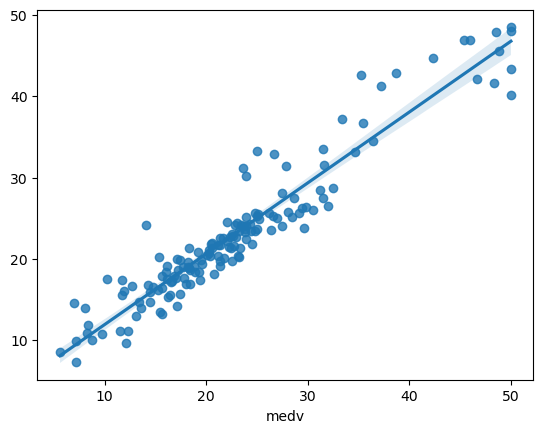

In [31]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()

gbr.fit(x_train_scaled, y_train)
y_pred_gbr=gbr.predict(x_test_scaled)
print("Scores of GB Regression:")
model_evaluate(y_test,y_pred)
sns.regplot(x=y_test,y=y_pred_gbr)
plt.show()

#### Creating dataframe with all scores of each model

In [32]:
regressors = {
    'Linear Regression' : lr,
    'Decision Tree' : DT,
    'K-nearest Neighbors' : knn,
    'Gradient Boost' : gbr
}
results=pd.DataFrame(columns=['Train Score', 'Test Score', 'MAE', 'MSE', 'R2-score'])
for method,func in regressors.items():
    pred = func.predict(x_test_scaled)
    results.loc[method]= [
                          func.score(x_train_scaled, y_train),
                          func.score(x_test_scaled, y_test),
                          np.round(mean_absolute_error(y_test,pred),3),
                          np.round( mean_squared_error(y_test,pred),3),
                          np.round(r2_score(y_test,pred),3)
                         ]
    
final_result=results.sort_values('R2-score',ascending=False).style.background_gradient(cmap='Greens',subset=['R2-score'])    
display(final_result)    

,Train Score,Test Score,MAE,MSE,R2-score
Gradient Boost,0.980374,0.903931,2.163000,8.837000,0.904000
Decision Tree,0.961310,0.798175,3.062000,18.564000,0.798000
K-nearest Neighbors,0.808468,0.764579,2.786000,21.654000,0.765000
Linear Regression,0.720785,0.719115,3.575000,25.836000,0.719000


From the above data, based on R2 score, gradient boost performed the best but train and test score tell that it got over fitted. So from other models, based on train score, test score, r2 score and MAE, we can say, KNN performed the best and KNN is the suitable model for this particular business problem.

In [34]:
pickle.dump(knn, open('knn_regressor.pkl', 'wb'))